<h2><center>Week 10: Unsupervised Learning (Part II)</center></h2>

<h3><center>CSCI-UA 9473 - Introduction to Machine Learning</center></h3>

<font color='green'><h2>Partial Solutions</h2> </font>


#### Exercise 1. White matter, Gray matter and cerebrospinal fluid

For this exercise, you will need to install nibabel. You can do this by typing the line 'pip install nibabel' in your terminal. 

We consider the MR image shown below. We want to segment this image into the white matter, gray matter and cerebrospinal fluid. 

 - Start by plotting the historgram of all pixel values (you can do this with 'numpy.histogram'). How does the distribution look like ? 

- Use your histogram to initialize the E-M algorithm (means and variance). The plot the resulting distributions on top ofthe histogram. Does your algorithm correctly capture the three clusters?

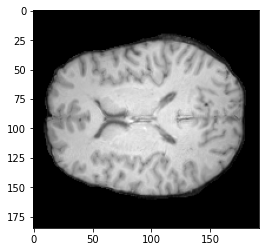

In [214]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

img = nib.load('T1.nii')
plt.imshow(img.dataobj[:,80,:], cmap = 'gray')

np_array = np.asarray(img.dataobj[:,80,:])

plt.show()

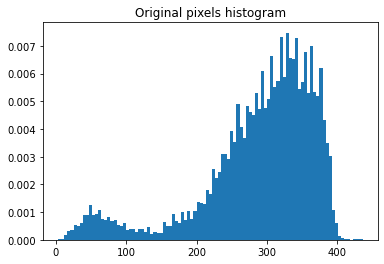

In [40]:
#### Exercise 2. Spectral clustering

pixel_list = np.reshape(np_array,np.shape(np_array)[0]*np.shape(np_array)[1])

pixel_list2 = np.delete(pixel_list, np.argwhere(pixel_list==0))
plt.hist(pixel_list2, bins=np.linspace(np.min(pixel_list2), np.max(pixel_list2),100), density=True)
plt.title('Original pixels histogram')
plt.show()


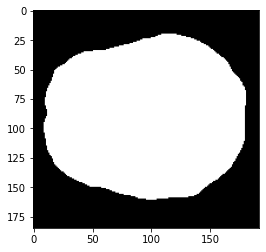

In [47]:
# finding the mask

mask = 0*np.ones(np.shape(np_array))

for i in np.arange(np.shape(np_array)[0]):
    for j in np.arange(np.shape(np_array)[1]):
    
        if np_array[i,j] >0:
            
            mask[i,j]=1
            
            
plt.imshow(mask,cmap = 'gray')
plt.show()

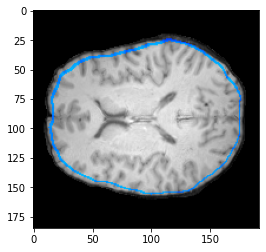

In [98]:
import cv2

kernel = np.ones((5,5), np.uint8)

img_erosion = cv2.erode(mask, kernel, iterations=2)
#img_dilation = cv2.dilate(mask, kernel, iterations=1)

# for display
kernel2 = np.ones((4,4), np.uint8)
img_erosion2 = cv2.erode(img_erosion, kernel2, iterations=1)
border = img_erosion - img_erosion2 

#image_contour = np.zeros(np.shape)
color_tmp = np.zeros((np.shape(np_array)[0], \
                      np.shape(np_array)[1], \
                     3))

for i in np.arange(3):
    
    color_tmp[:,:,i] = np_array[:,:]/np.max(np_array)

border_c = np.squeeze(np.where(border==1))

for k in np.arange(len(border_c[0,:])):
    
    color_tmp[border_c[0,k],border_c[1,k],0:1] = 0 
    color_tmp[border_c[0,k],border_c[1,k],2] = 1 
    
plt.imshow(color_tmp)
plt.show()


In [99]:
ind1 = np.squeeze(np.where(img_erosion==1))
np.shape(ind1)

(2, 16900)

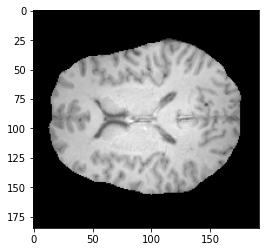

In [100]:
cropped_image = np.zeros(np.shape(img_erosion))

for k in np.arange(len(ind1[0,:])):

    if img_erosion[ind1[0,k], ind1[1,k]]==1:
        cropped_image[ind1[0,k], ind1[1,k]] = np_array[ind1[0,k], ind1[1,k]]

plt.imshow(cropped_image, cmap = 'gray')
plt.show()




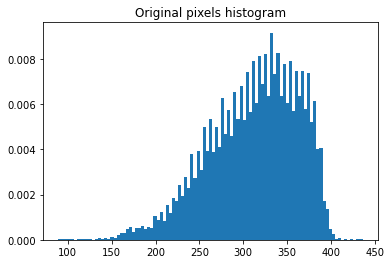

In [223]:

pixel_list = np.reshape(cropped_image,np.shape(cropped_image)[0]*np.shape(cropped_image)[1])

pixel_list2 = np.delete(pixel_list, np.argwhere(pixel_list==0))
plt.hist(pixel_list2, bins=np.linspace(np.min(pixel_list2), np.max(pixel_list2),100), density=True)
plt.title('Original pixels histogram')
plt.show()


Text(0.5, 1.0, 'Reconstructed Image')

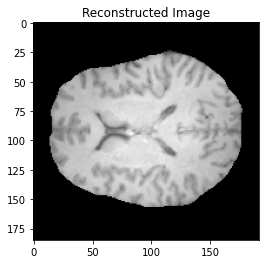

In [195]:
# optional median filter 
from scipy import ndimage, misc 
filtered_image = ndimage.median_filter(cropped_image,[2,2])

plt.figure()
plt.imshow(filtered_image, plt.cm.gray)
plt.title('Reconstructed Image')

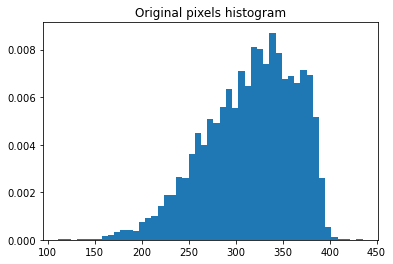

In [200]:
pixel_list = np.reshape(filtered_image,np.shape(cropped_image)[0]*np.shape(cropped_image)[1])

pixel_list2 = np.delete(pixel_list, np.argwhere(pixel_list<100))
plt.hist(pixel_list2, bins=np.linspace(np.min(pixel_list2), np.max(pixel_list2),50), density=True)
plt.title('Original pixels histogram')
plt.show()

In [254]:
import copy 


# Initialization

mu1 = 100
mu2 = 200
mu3 = 300

mu = np.asarray([mu1, mu2, mu3])

sigma1 = 20
sigma2 = 20
sigma3 = 10

sigma = np.asarray([sigma1, sigma2, sigma3])

phi1 = .8
phi2 = .1
phi3 = .1

phi = np.asarray([phi1, phi2, phi3])


num_clusters = 3

criterion = 10

maxIter = 500

criterion_mu = np.zeros((maxIter,))
criterion_sigma = np.zeros((maxIter,))
criterion_phi = np.zeros((maxIter,))
    

for kk in np.arange(maxIter):

    # E-step 
    
    gamma = np.zeros((len(pixel_list2), num_clusters))
    numerator = np.zeros((len(pixel_list2), num_clusters))
    denominator = np.zeros((len(pixel_list2),))
    
    for j in np.arange(num_clusters):

        numerator[:,j] = np.squeeze(np.exp(-np.power(pixel_list2- mu[j], 2.) / (2 * np.power(sigma[j], 2.)))*phi[j])
        denominator+= numerator[:,j]

    for j in np.arange(num_clusters):
            
        gamma[:,j] = np.divide(numerator[:,j],denominator)

    # M-step 
    
    mu_old = copy.deepcopy(mu)
    sigma_old = copy.deepcopy(sigma)
    phi_old = copy.deepcopy(phi)
    
    for j in np.arange(num_clusters):

        
        tmp = np.dot(gamma[:,j],pixel_list2)
        mu[j] = tmp/np.sum(gamma[:,j])


        tmp = np.dot(gamma[:,j],(pixel_list2 - mu_old[j])**2)/np.sum(gamma[:,j])
        sigma[j] = np.sqrt(tmp)


        phi[j] = np.sum(gamma[:,j])/len(pixel_list2)
        
        
    criterion_mu[kk] = np.sqrt(np.sum((mu.reshape(-1,1)-mu_old.reshape(-1,1))**2))
    criterion_sigma[kk] = np.sqrt(np.sum((sigma.reshape(-1,1)-sigma_old.reshape(-1,1))**2))
    criterion_phi[kk] = np.sqrt(np.sum((phi.reshape(-1,1)-phi_old.reshape(-1,1))**2))
    

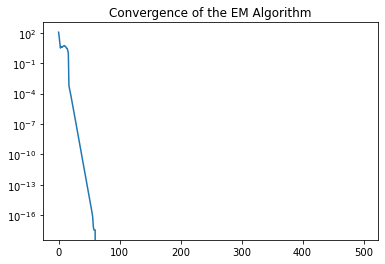

In [255]:
plt.semilogy(criterion_mu+criterion_sigma+criterion_phi)
plt.title('Convergence of the EM Algorithm')
plt.show()

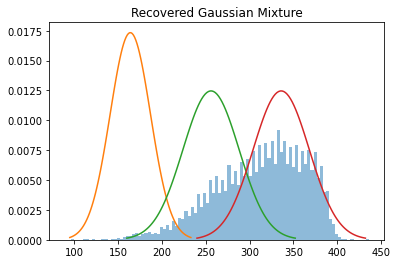

In [256]:
import scipy.stats as stats
import math

numClasses = 3
plt.hist(pixel_list2, bins=np.linspace(np.min(pixel_list2), np.max(pixel_list2),100), density=True, alpha=0.5)

for i in np.arange(numClasses):
    
    
    x = np.linspace(mu[i] - 3*sigma[i], mu[i] + 3*sigma[i], 100)
    plt.plot(x, stats.norm.pdf(x, mu[i], sigma[i]))
    
plt.title('Recovered Gaussian Mixture')
plt.show()

To recover the independent regions, we take for each pixel the Gaussian that returns the highest probability


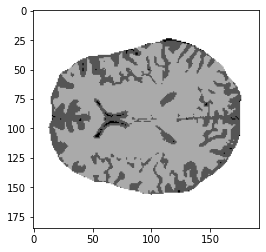

In [259]:
import numpy.matlib

max_row = np.arange(np.shape(np_array)[0]).reshape(-1,1)
max_col = np.arange(np.shape(np_array)[1]).reshape(-1,1).T

row_ind = np.tile(max_row, [1,np.shape(np_array)[1]])
col_ind = np.tile(max_col, [np.shape(np_array)[0],1])

list_rind = np.reshape(row_ind,np.shape(np_array)[0]*np.shape(np_array)[1])
list_cind = np.reshape(col_ind,np.shape(np_array)[0]*np.shape(np_array)[1])


list_rind = np.delete(list_rind,np.argwhere(pixel_list<5))
list_cind = np.delete(list_cind,np.argwhere(pixel_list<5))

segmented_image = 3*np.ones(np.shape(np_array))

for i in np.arange(len(list_rind)):
    
    segmented_image[list_rind[i], list_cind[i]] = np.argmax(gamma[i,:])
    
plt.imshow(segmented_image, cmap='gray')
plt.show()


In [130]:
print(np.max(gamma[:,2]))




4.565117792090513e-93


### Exercise 2.  Image compression 


#### 2.1. plotting the eigenvalues

Consider the simple image given below. We would like to compress this image by means of principal component factorization. For this purpose, we will see the columns as our feature vectors. Build the covariance matrix associated to the columns of the image (don't forget to center them first) and plot the eigenvalues associated to this covariance matrix. What do you notice?   

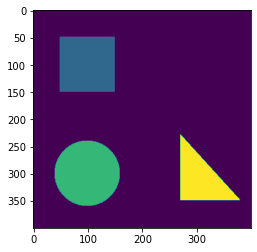

In [2]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

img = Image.open('shapes.png')
data1 = np.array(img)

plt.imshow(data1)
plt.show()

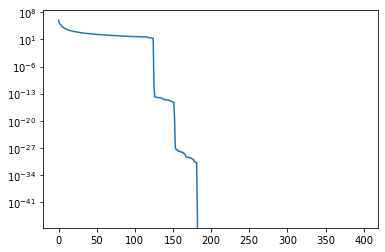

In [3]:
mean_col = np.mean(img, axis=1)

centered_image = img - np.matmul(mean_col.reshape(-1,1), np.ones((1, np.shape(img)[1])))


covariance = (1/np.shape(img)[1]) * np.matmul(centered_image, centered_image.T)

w, v = np.linalg.eig(covariance)

# sort the eigenvalues in decreasing order

wsorted_indices = np.argsort(w)[::-1]


w_sorted = w[wsorted_indices]
v_sorted = v[:,wsorted_indices]

plt.semilogy(np.real(w_sorted))
plt.show()


#### 2.2. projection onto the principal vectors

Given your result from the previous question, compress the image by computing its principal component factorization for increasing numbers of components. Compare the reconstructions.

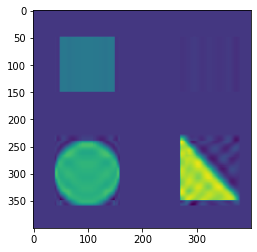

In [4]:
subspace = np.real(v_sorted[:,:8])

reconstructed_image = np.matmul(subspace, np.matmul(subspace.T, img))

plt.imshow(reconstructed_image)
plt.show()

#### Exercise 3: Face recognition

In this exercise, we consider the 'Labeled Faces in the Wild' dataset from UM Amherst. We would like to train a Maximum margin classifier on this dataset (scikit learn 'svm') with a Gaussian kernel. In its original form, the dimensionality of the data is too high (if we used the raw images as our feature vectors, each vector would encode 75$\times$56 features). Although it can sometimes be a blessing, high dimensionality can also be a curse. Working in a high dimensional space means that the feature vectors will be very distant from each other which could result in a meaningless classifier. To avoid this, we will start by computing a principal component decomposition of our set of images. The SVM classifier will then be applied on the PCA representation of the training images. 

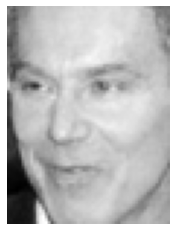

In [5]:
import numpy as np

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=.6)

n_samples, h, w = lfw_people.images.shape

images = lfw_people.data
targets = lfw_people.target

training_images, test_images, train_targets, test_targets = \
train_test_split(images,targets, test_size = .10, random_state=10)

plt.imshow(training_images[0,:].reshape(h,w), cmap='gray')
plt.axis('off')
plt.show()

#### Question 3.1. PCA decomposition

- Extract the first 50, 100, 200 and 300 principal components from the image dataset and display the corresponding reconstruction for one of the faces. 


- Display the plot of the reconstruction error (deviation between the true image and its PCA reconstruction for K=1 to h*w)


- Finally, plot each of the principal images for K=1,...10

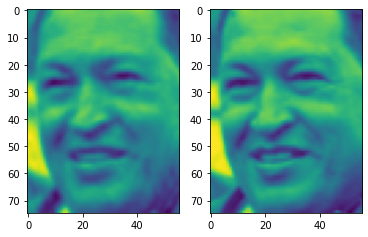

In [6]:
import numpy as np
from sklearn.decomposition import PCA

# put your code here 

import numpy as np
from sklearn.decomposition import PCA


pca = PCA(n_components=300, whiten=True)
latent_rep = pca.fit_transform(training_images)

reconstructed_image0 = pca.inverse_transform(latent_rep[2,:])

plt.subplot(1, 2, 1)
plt.imshow(reconstructed_image0.reshape(h, w))

plt.subplot(1, 2, 2)
plt.imshow(training_images[2,:].reshape(h, w))

plt.show()

#### Question 3.2. 

Now that we have a PCA decomposition, we can learn our Max Margin classifier. We will do this with the svc model of scikit learn. finding the optimal parameters is a little tricky because of the dimension. One approach is to carry out cross validation over a parameter grid. To spare the search for the parameter values, this step is implemented below. 

- Complete the code below with the training of the Max Margin classifier (remember to split your dataset between a training and validation part).


- Once you have trained the SVC, apply it on the test set and display the predictions vs actual targets. 

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)


clf.fit(latent_rep, train_targets)


GridSearchCV(estimator=SVC(class_weight='balanced'),
             param_grid={'C': [1000.0, 5000.0, 10000.0, 50000.0, 100000.0],
                         'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]})

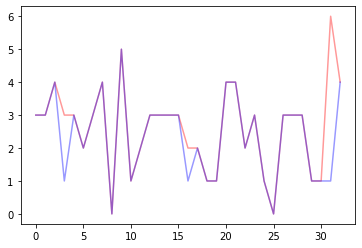

In [18]:

latent_rep_test = pca.transform(test_images)

predicted_targets = clf.predict(latent_rep_test)

plt.plot(test_targets[::4], '-r', alpha=0.4)
plt.plot(predicted_targets[::4], '-b', alpha=0.4)
plt.show()

In [55]:
from sklearn.metrics import accuracy_score

accuracy_score(test_targets, predicted_targets)

0.8294573643410853

### II. Independent component analysis: The coktail party 

In this exercise, we will use another approach to dimensionality reduction, known as independent component analysis (ICA). ICA is particularly useful in speech or more generally, source separation. In the classical version of this problem, known as "The coktail party problem", one is interested in recovering two distinct signals from their mixing. 

<img src="ConversationMovie.jpg" alt="Drawing" style="width: 400px;"/>

image credit:  [The conversation](https://en.wikipedia.org/wiki/The_Conversation) 

__Exercise II.4.a.__ Using the FastICA transform from scikit-learn, recover the two speeches from the mixed1.wav and mixed1.wav files which are given on github. 

(Hint: start by storing the two signals 'samples1' and 'samples1' into a single matrix, then pass this matrix as an input to the FastICA method of Scikit-learn) 

Automatically created module for IPython interactive environment


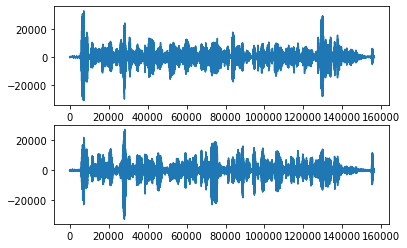

In [14]:
print(__doc__)

import os
import wave
import pylab
import matplotlib

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

from sklearn.decomposition import FastICA, PCA

###############################################################################


# read data from wav files
sample_rate1, samples1 = wavfile.read('mixed1.wav')
sample_rate2, samples2 = wavfile.read('mixed2.wav')

fig, axs = plt.subplots(2)
axs[0].plot(samples1)
axs[1].plot(samples2)
plt.show()

# add your code here

observations = np.vstack((samples1, samples2))
from sklearn.decomposition import FastICA
ICAtransform = FastICA(n_components=2)

S = ICAtransform.fit_transform(observations.T)
A = ICAtransform.mixing_  

(156239, 2)


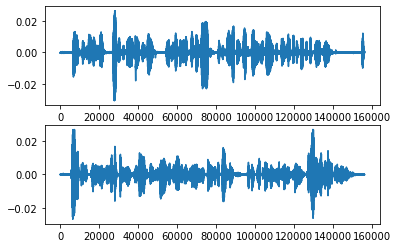

In [15]:
print(np.shape(S))

fig, axs = plt.subplots(2)
axs[0].plot(S[:,0])
axs[1].plot(S[:,1])
plt.show()

__Exercise II.4.b.__ Once you have recovered the original signals, plot them as time series. Then use the lines below to store them in new .wav file. Then play them and compare them with their mixings.

In [ ]:
# write data to wav files

scaled1 = np.int16(S[:,0]/np.max(np.abs(S[:,0])) * 32767)
wavfile.write('recovered-1DemoJune28.wav', sample_rate1, scaled1)

scaled2 = np.int16(S[:,1]/np.max(np.abs(S[:,1])) * 32767)
wavfile.write('recovered-2DemoJune28.wav', sample_rate2, scaled2)
